# Dimensionality Reduction and Clustering

## This notebook will briefly run through a variety of models that will attempt to classify the images within our dataset.  
## The models examined will be:
## 1.PCA
## 2.t-SNE
## 3.k-means Clustering
## 4.Hierarchical Clustering

I start below by importing various packages and libraries, as well as importing the data and separating the data set into correct labels- Y and the set of features- X.  After glancing around at their shape for a moment, I head right into PCA

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp

from sklearn import linear_model
from sklearn import metrics
from sklearn.grid_search import GridSearchCV

import seaborn as sns
import missingno as msno

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error
import pprint
from sklearn.metrics import precision_recall_fscore_support

In [2]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")
X = mnist.data / 255.0
Y = mnist.target

In [71]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [72]:
X.shape

(70000, 784)

In [73]:
Y

array([0., 0., 0., ..., 9., 9., 9.])

In [74]:
Y.shape

(70000,)

# 1. PCA

In [75]:
from sklearn.decomposition import PCA

Right out of the gate I decided to visualize the explained variance ratio for a large swath of possible numbers of components (in this case up to 100 components)

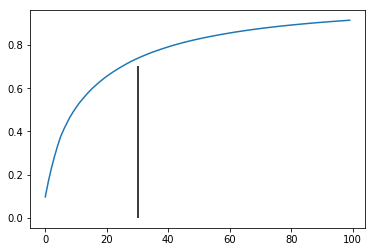

In [77]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.vlines(ymin=0,ymax=cum_ratio[25],x=30)

While there's not an incredibly distinct elbow in the figure above, I did denotate with a line about where I pictured the theoretical elbow. This line was at the 30 component mark, but while additional components do seem to experience decreasing returns in form of variance explained after that point, 30 components still only explains about 70% of the variance, and I think we can do better than that.

It was suggested in the lecture that choosing a number of components that explain 95% of the variance could be a useful benchmark.  However, seeing a that our graph of the explained variance ration doesn't even reach 95% within visible range (and proven by trying to project how many components we would need to cover 95% of the variance) I chose 85% as a reasonable goal instead- seeing how the curve is fairly level after 30 or so components anyways.  

In [78]:
index_95 = np.argmax(cum_ratio >= 0.85)
print(index_95)
print(cum_ratio[index_95])

58
0.8508242357853544


Using our function to determine how many components would be needed to predict 85% of the variance, we see that with 59 components, we can explain 85.1% of the variance in our dataset. 

I therefore fit a model to our 59 component framework before proceeding to create a 2 component framework that we can both visualize and then compare against our 59 component model. 

In [79]:
pcaFinal = PCA(n_components=59)
X_pcaFinal = pcaFinal.fit_transform(X)

In [117]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X)

In [145]:
principalDf = pd.DataFrame(X_pca2
             , columns = ['principal component 1', 'principal component 2'])
principalDf['label'] = Y[rows]

finalDf = pd.DataFrame(X_pcaFinal)
finalDf['label'] = Y[rows]

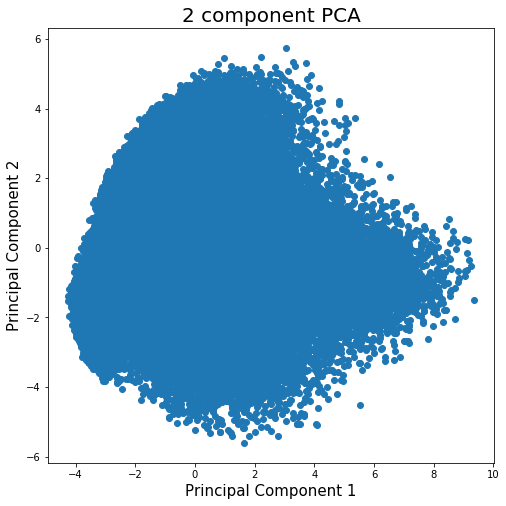

In [82]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
plt.scatter(principalDf.values[:,0], principalDf.values[:,1])

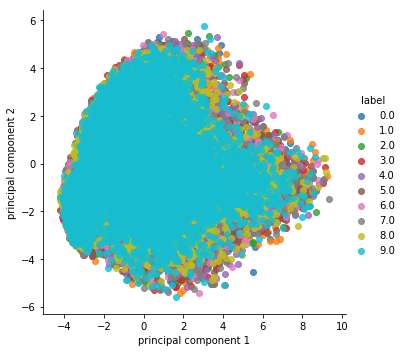

In [140]:
sns.lmplot(x='principal component 1', y='principal component 2', data=principalDf, hue='label', fit_reg=False)

In [83]:
pca2.explained_variance_ratio_

array([0.09746116, 0.07155445])

Looking at the graphs above, with two components all we can really see is a big blob.  It appears that 2 components really can't capture much of the variance at all, or we might see a more distinctive pattern of our plotted points.  However, using our explained variance ratio we can see that even though those two components look like a mess visually, they do explain about 17% of the variance between them, which isn't too shabby.  A far cry from the 85% that 59 components will give us though. 

The effect of just 2 components is impressive, given that the original data has 784 features, that we were able to produce just 2 components that explain 17% of the variance between those 784 variables is fantastic.  This shows the usefullness of PCA as a dimensionality reduction strategy that allows us to simplify datasets with large numbers of features.

Though PCA tends to overfit, and could likely do so if we used an even larger number of components than we plan to, it provides a relatively simple and computationally inexpensive way to reduce many dimensional data to a workable form.

I'm now going to prepare our 2 PCA models to plot compressed images of our data based on their components.

In [124]:
approximation = pca2.inverse_transform(X_pca2)
approximationF = pcaFinal.inverse_transform(X_pcaFinal)

Below I've examined how these various data compression strategies compares to the original data.  In each set, the first image is the original data image, the second image is the same image using a 2 component principal analysis, and the third is from the full 59 component principal analysis that I chose to represent 85% of the variance.  

The differences are pretty evident, but the 59 component is impressively accurate. 

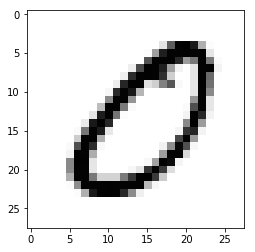

In [84]:
plt.imshow(X[283].reshape((28,28)), cmap='Greys')

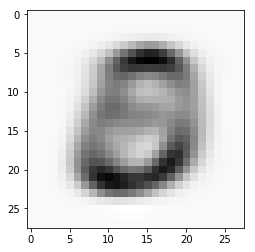

In [121]:
plt.imshow(approximation[283].reshape(28,28), cmap='Greys')

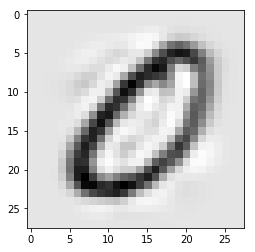

In [125]:
plt.imshow(approximationF[283].reshape(28,28), cmap='Greys')

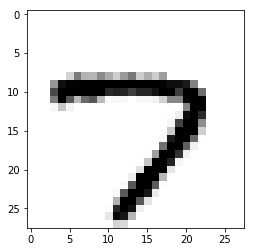

In [44]:
plt.imshow(X[67473].reshape((28,28)), cmap='Greys')


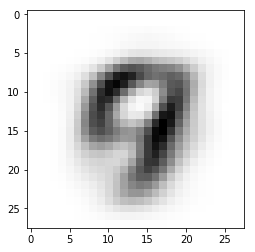

In [129]:
plt.imshow(approximation[67473].reshape((28,28)), cmap='Greys')

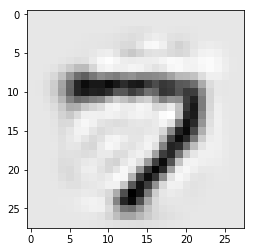

In [128]:
plt.imshow(approximationF[67473].reshape((28,28)), cmap='Greys')

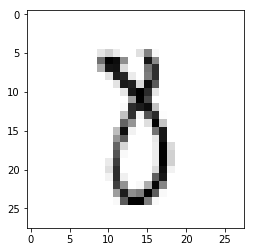

In [45]:
plt.imshow(X[49545].reshape((28,28)), cmap='Greys')


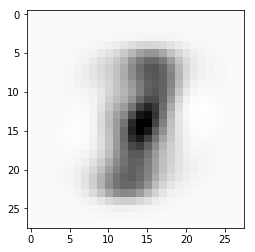

In [123]:
plt.imshow(approximation[49545].reshape(28,28), cmap='Greys')

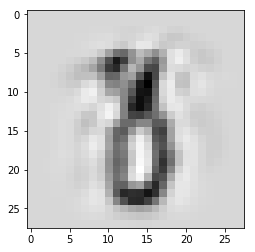

In [130]:
plt.imshow(approximationF[49545].reshape(28,28), cmap='Greys')

# 2. t-SNE

In [192]:
from sklearn.manifold import TSNE

Our t-SNE model will be best suited to visualizing two-dimensional data, and so we will use the first 2 components of our PCA model as targets of visualization in the models below.

First, because the data set is so massive, we randomly select a subset of the points to run through the t-SNE model.  Below is our first plot.

In [133]:
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.097s...
[t-SNE] Computed neighbors for 10000 samples in 46.372s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.088106
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.459534
[t-SNE] Error after 1000 iterations: 1.689087


In [142]:
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = Y[rows[:n_select]]

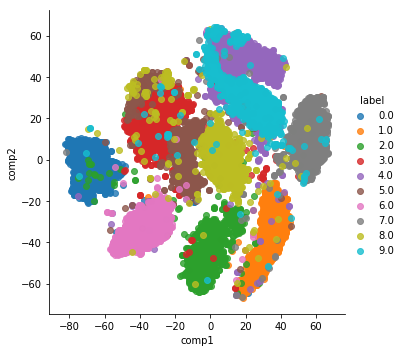

In [143]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)


This plot definitely features much more distinct clusters than our 2 component PCA plot.  In this plot it is easy to see that the model is fairly accurately able to sort the images fed to it by the number they contain. 

Below I run the model again, but with differing values of perplexity, learning rate, and iterations.

## Varying Perplexity

In [150]:
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.103s...
[t-SNE] Computed neighbors for 10000 samples in 45.035s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.916159
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.201065
[t-SNE] Error after 1000 iterations: 1.805829


In [151]:
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = Y[rows[:n_select]]

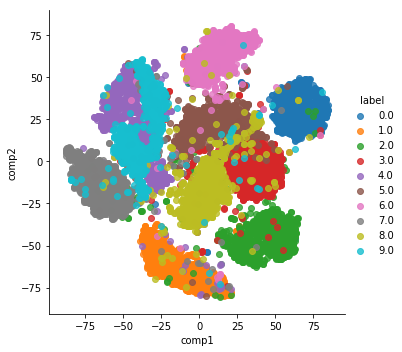

In [152]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)


In [153]:
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000

tsne = TSNE(n_components=2, verbose=1, perplexity=8, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.098s...
[t-SNE] Computed neighbors for 10000 samples in 41.650s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.432098
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.138565
[t-SNE] Error after 1000 iterations: 1.954851


In [154]:
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = Y[rows[:n_select]]

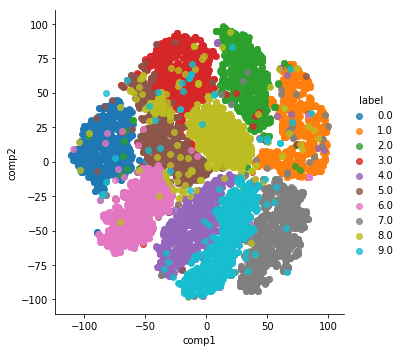

In [155]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)


In the two plots above I brought the perplexity down from its original value of 50 to 30 and then to 8. Given that these values encompass nearly the whole scale of recommended perplexity values, I would have expected to see more difference between the plots.  However, this model appears pretty robust to changes in perplexity, with the low perplexity clusters being a little less separated, but still hardly differing from the other plots in a noticeable way. 


## Varying Number of Iterations

In [156]:
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=2000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.118s...
[t-SNE] Computed neighbors for 10000 samples in 44.566s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.913129
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.951515
[t-SNE] Error after 2000 iterations: 1.750111


In [157]:
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = Y[rows[:n_select]]

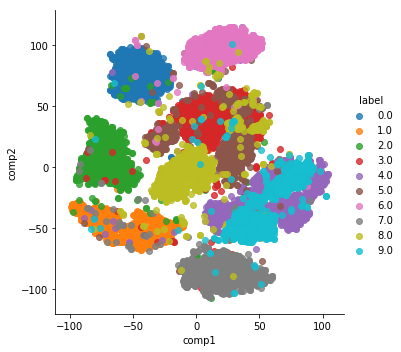

In [158]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)


In [159]:
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.110s...
[t-SNE] Computed neighbors for 10000 samples in 44.469s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.919005
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.378227
[t-SNE] Error after 500 iterations: 2.067692


In [160]:
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = Y[rows[:n_select]]

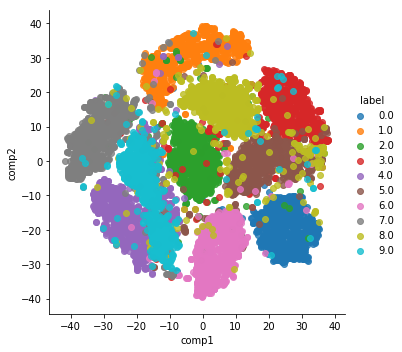

In [161]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)


In the two graphs above I first doubled the number of iterations run from its original value of 1000 to 2000, then halved the original value and used 500 iterations.  Again, the plot appears much the same across all three values.  It may be due to the fact that spatial distance doesn't really mean anything in t-SNE visualization, but I'm not really even sure if any observed differences in space between clusters matters.  If it does, the higher iteration number does show a bit more spatial isolation of clusters than the lower values.

## Varying Learning Rate

In [162]:
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500, learning_rate=100)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.102s...
[t-SNE] Computed neighbors for 10000 samples in 47.155s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.915476
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.831573
[t-SNE] Error after 500 iterations: 2.216532


In [163]:
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = Y[rows[:n_select]]

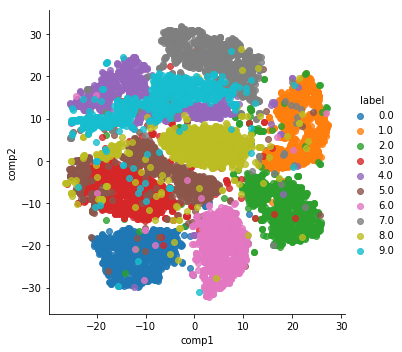

In [164]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)


In [165]:
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500, learning_rate=50)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.098s...
[t-SNE] Computed neighbors for 10000 samples in 45.021s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.910982
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.370415
[t-SNE] Error after 500 iterations: 2.369447


In [166]:
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = Y[rows[:n_select]]

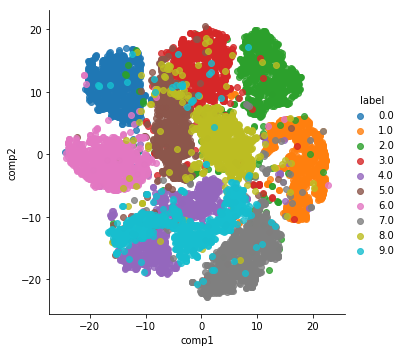

In [167]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)


In the above two graphs I halved the original learning rate from 200 to 100, and then again from 100 to 50.  Adjusting the learning rate appeared to affect the plots more than adjusting the other parameters did, and the clusters do appear less distinct and more messy and overlapping as the learning rate decreases.  This parameter seems to be less robust to changes. 

# 3. K Means Clustering

In [28]:
from sklearn.cluster import KMeans

Although we know that our data needs to be separated into 10 clusters, since we have 10 label values, I decided to plot an elbow graph as if I were approaching an unsupervised dataset and see what number of clusters the graph would recommend. 

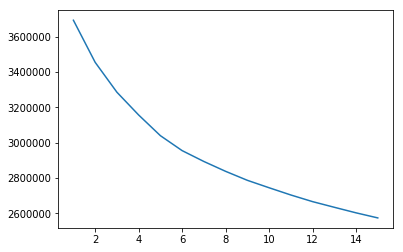

In [169]:
sses = []
for k in range(1,16):
    kmeans = KMeans(n_clusters=k, n_init=50, n_jobs=-1)
    kmeans.fit(X)
    sses.append(kmeans.inertia_)
plt.plot(range(1,16), sses)

Looking at the graph, though there is a slight elbow around 5 clusters, the line descends pretty uniformly until 16, suggesting as many as 16 clusters could be useful in separating the data. 

Buts, as said before, we know that the data should be split into 10 clusters, so I used that value of k in the model below.   

I first run an unscaled model, followed by an otherwise identical model on scaled data. 

In [199]:
kmeans = KMeans(n_clusters=10, n_init=30, n_jobs=-1)
kfit = kmeans.fit_transform(X)
sk_clusters1 = kmeans.predict(X)

In [179]:
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500, learning_rate=50)
tsne_results = tsne.fit_transform(kfit[rows[:n_select],:])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.010s...
[t-SNE] Computed neighbors for 10000 samples in 1.128s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.542590
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.401794
[t-SNE] Error after 500 iterations: 2.282838


In [181]:
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = Y[rows[:n_select]]

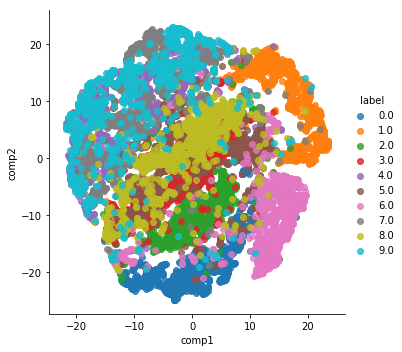

In [182]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)


After training the model I immediately visualized it using t-SNE, so that we could see how effective it appeared to be.  

This plot shows that the clusters are not very distinct- definitely less so than the t-SNE models run before.  

Using the rand score metric below which compares our models predicted labels to the true labels we are able to see that our model is not performing so well, only correctly identifying about 36% of the data.  

In [200]:
from sklearn import metrics
metrics.adjusted_rand_score(sk_clusters1, Y)

0.3652393015109813

Now we'll see if the model performs better using scaled data.

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [193]:
kmeans = KMeans(n_clusters=10, n_init=30, n_jobs=-1)
kfit = kmeans.fit_transform(X_scaled)
sk_clusters = kmeans.predict(X_scaled)

In [194]:
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500, learning_rate=50)
tsne_results = tsne.fit_transform(kfit[rows[:n_select],:])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.016s...
[t-SNE] Computed neighbors for 10000 samples in 1.627s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.209713
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.358513
[t-SNE] Error after 500 iterations: 2.048158


In [195]:
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = Y[rows[:n_select]]

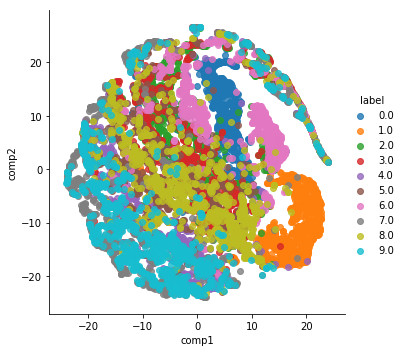

In [196]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)


Yikes- it looks like scaling the data in this case has, in fact, made it harder for our model to differentiate the data in the images.  Looking above, our graph is a rainbow stew, and few clusters are distinct in any way. 

In [197]:
from sklearn import metrics
metrics.adjusted_rand_score(sk_clusters, Y)

0.3206347193815963

And the metrics reveal that.  This rand score has our classification guessing correctly 32% of the time (though that's not much better than the non-scaled kmeans model, which earned a 36%).

# 4. Hierarchichal Clustering

Moving into hierarchichal clustering, I plotted several dendrograms- all using the same randomly generated subset of 100 points from the data set- starting with the complete linkage method (of which there is also a truncated version) and into single, average, weighted, and ward.  

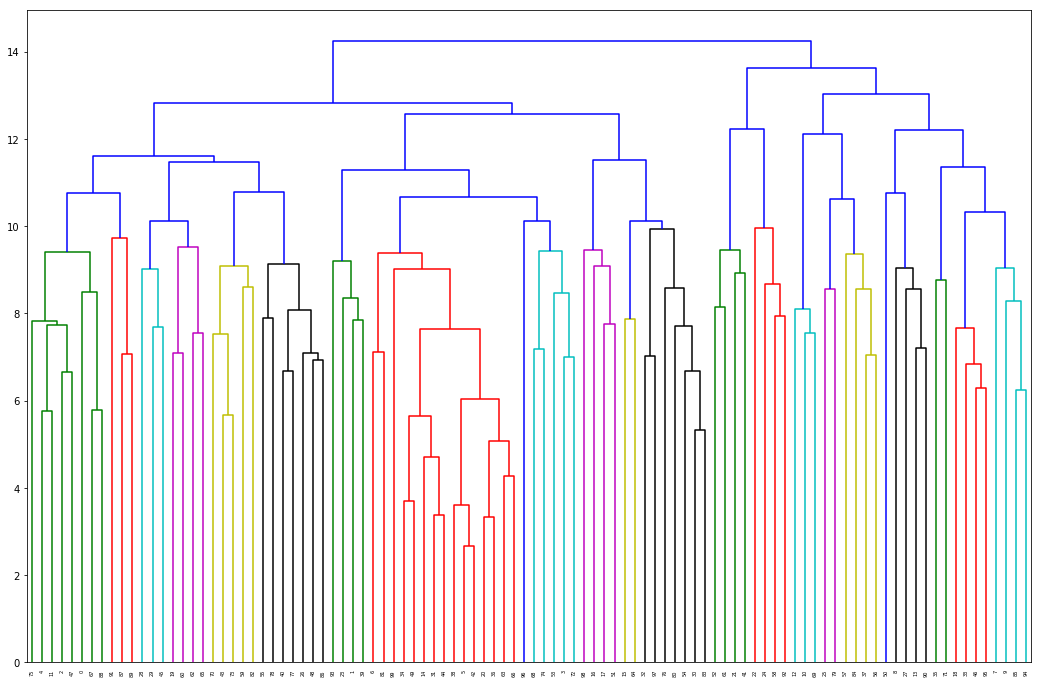

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage

rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 100

Z = linkage(X[rows[:n_select],:], 'complete')
plt.figure(figsize=(18, 12))
_ = dendrogram(Z)

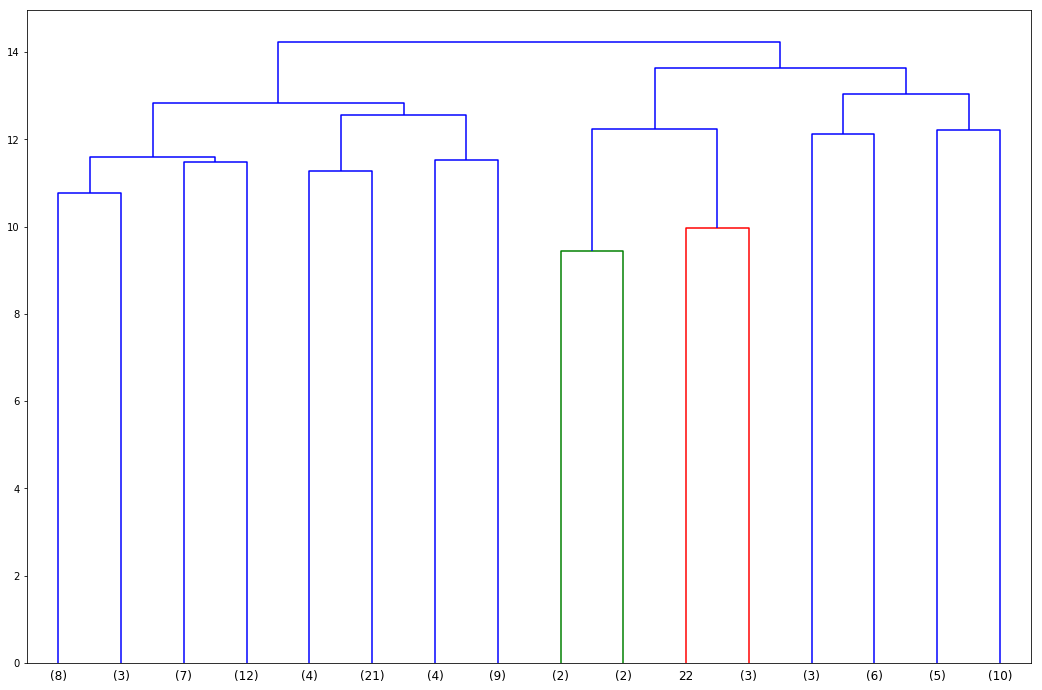

In [37]:
Z = linkage(X[rows[:n_select],:], 'complete')
plt.figure(figsize=(18, 12))
_ = dendrogram(Z, p=3, truncate_mode='level')

Using this truncated graph it seems reasonable to use 16 clusters, as counted by the number of vertical line paths shown at this level.  Again, I know that 10 is the correct number, so it's interesting to look at possible other numbers of clusters.

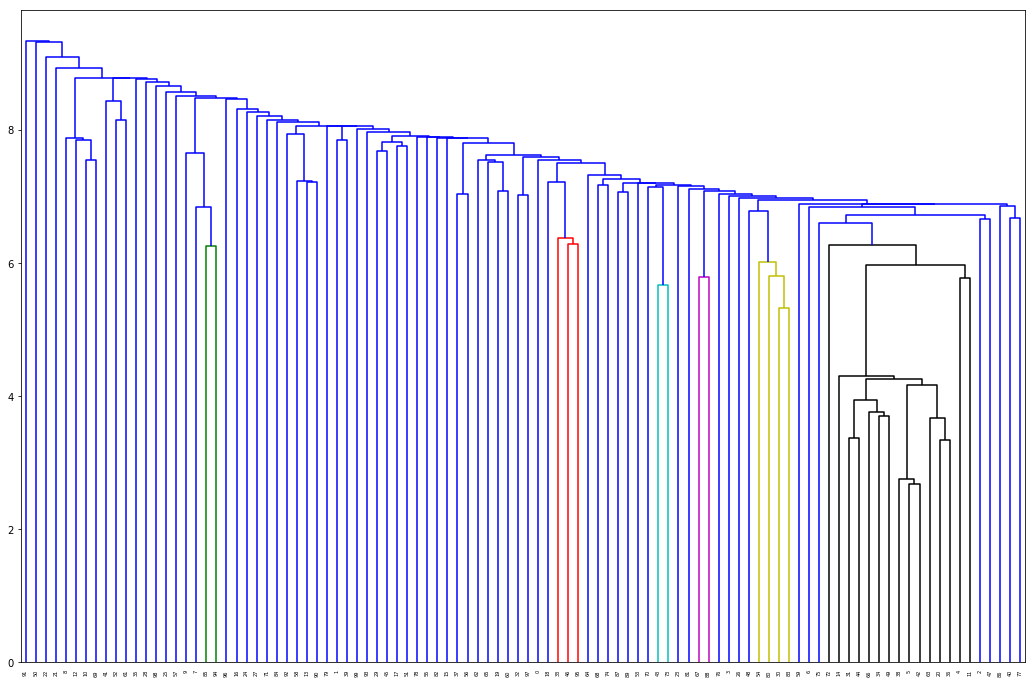

In [23]:
Z = linkage(X[rows[:n_select],:], 'single')
plt.figure(figsize=(18, 12))
_ = dendrogram(Z)

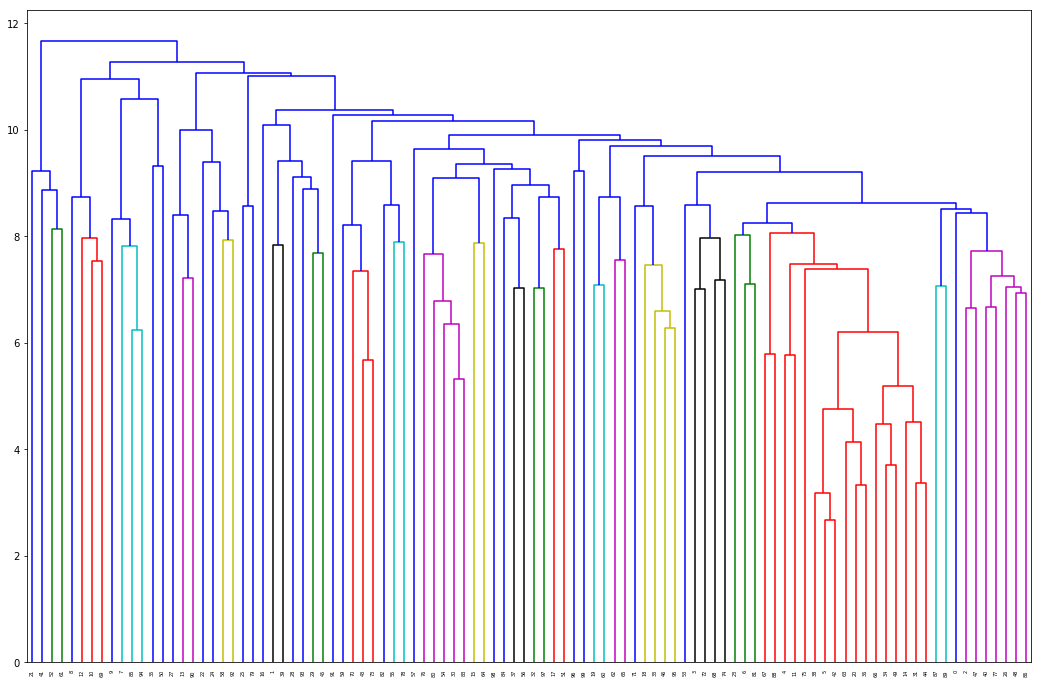

In [24]:
Z = linkage(X[rows[:n_select],:], 'average')
plt.figure(figsize=(18, 12))
_ = dendrogram(Z)

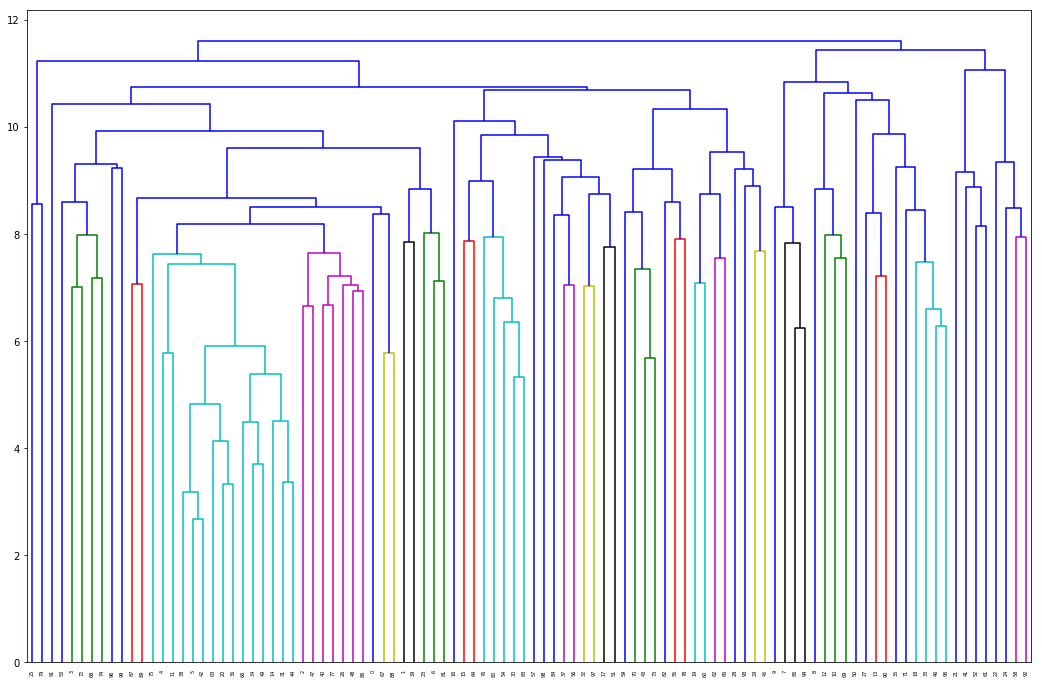

In [25]:
Z = linkage(X[rows[:n_select],:], 'weighted')
plt.figure(figsize=(18, 12))
_ = dendrogram(Z)

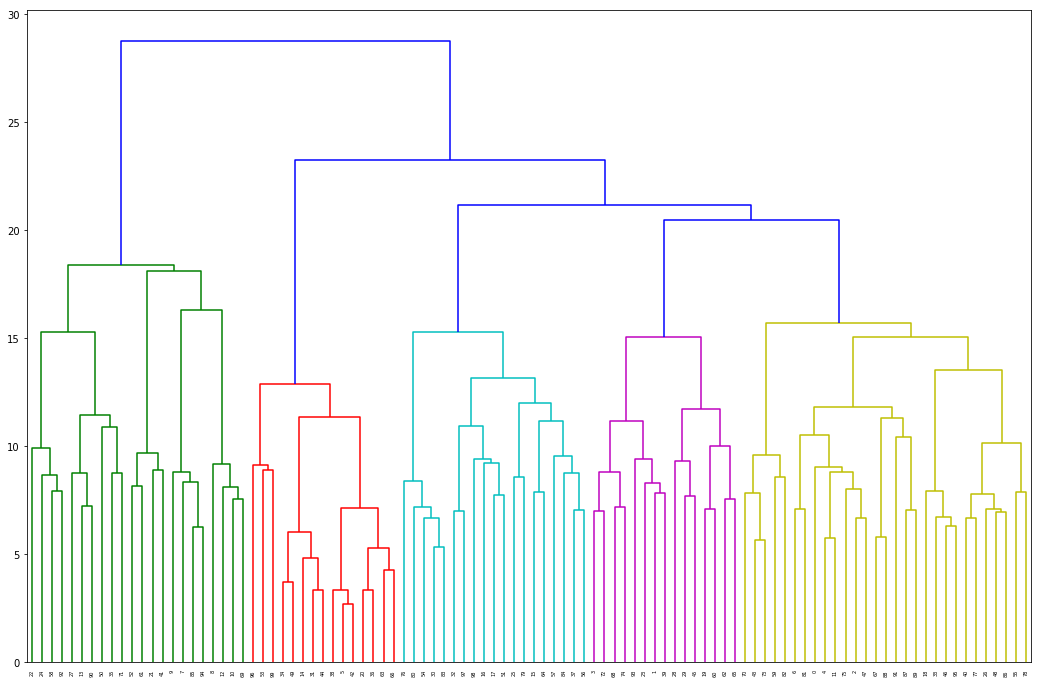

In [26]:
Z = linkage(X[rows[:n_select],:], 'ward')
plt.figure(figsize=(18, 12))
_ = dendrogram(Z)

Overall, altering methods of linkage changes the structure of the dendogram, with the single tightly clustered and branching one by one, the ward highly differentiated into 5 main groupings, and the other models everywhere inbetween.  